In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

from xgboost import XGBRegressor
from scipy.optimize import minimize


Загрузка таблицы

In [101]:
def load_data(file_path):
    df = pd.read_excel(file_path, header=7)
    return df

df = load_data("Реклама_в_поиске_по_запросу_футболка_белая_женская_1.xlsx")
df.head()

,Артикул,Дата создания,Выручка,Заказы,Средняя цена без СПП,Средний чек,Коэффициент демпинга,Остатки на конец периода,Дней в наличии,Дней отсутствовал,...,Бренд,Предмет,Позиция в выдаче,Стоимость за 1000 показов,Тип рекламы,Буст на позицию,Буст с позиции,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,32395071,2021-06-22,15742625,11885,1337.10,1324.58,0.94,18474,30,0,...,286253,Футболки,9,991,c,9,301,NaN,NaN,id
1,101717864,2022-09-20,5485727,8755,632.80,626.58,0.98,3687,30,0,...,359670,Футболки,17,670,c,17,301,NaN,NaN,целевое значение
2,336181959,2025-02-23,2207372,2684,822.07,822.42,0.00,1010,30,0,...,2697,Футболки,21,551,c,21,301,NaN,NaN,NaN
3,64000093,2022-05-11,575683,613,949.67,939.12,1.11,1475,30,0,...,76251,Футболки,27,501,c,27,301,NaN,NaN,весомый признак
4,242710131,2024-09-10,2592674,2367,1102.03,1095.34,0.61,7092,30,0,...,311466861,Футболки,50,157,b,50,301,NaN,NaN,NaN


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Артикул                              100 non-null    int64  
 1   Дата создания                        100 non-null    object 
 2   Выручка                              100 non-null    int64  
 3   Заказы                               100 non-null    int64  
 4   Средняя цена без СПП                 100 non-null    float64
 5   Средний чек                          100 non-null    float64
 6   Коэффициент демпинга                 100 non-null    float64
 7   Остатки на конец периода             100 non-null    int64  
 8   Дней в наличии                       100 non-null    int64  
 9   Дней отсутствовал                    100 non-null    int64  
 10  Доля дней в наличии                  100 non-null    float64
 11  Среднее кол-во заказов при наличи

In [103]:
df.isnull().sum()

,0
Артикул,0
Дата создания,0
Выручка,0
Заказы,0
Средняя цена без СПП,0
Средний чек,0
Коэффициент демпинга,0
Остатки на конец периода,0
Дней в наличии,0
Дней отсутствовал,0


In [104]:
#Предобработка данных

def preprocess_data(df, target='Позиция в выдаче'):
    # Удаление ненужных столбцов
    cols_to_drop = [
        'Дата создания', 'Выручка', 'Выручка в день при наличии товаров', 'Упущенная выручка',
        'Название', 'Поставщик', 'Бренд', 'Предмет', 'Стоимость за 1000 показов',
        'Тип рекламы', 'Буст на позицию', 'Буст с позиции', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29'
    ]
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    df = df.drop(columns=cols_to_drop)

    # Удаление строк с пропусками в целевой переменной
    df = df.dropna(subset=[target])

    # Удаление дубликатов
    df = df.drop_duplicates()

    # Удаление сильно коррелирующих признаков
    corr_matrix = df.corr()
    selected_features = []
    threshold = 0.9
    for col in corr_matrix.columns:
        high_corr = False
        for other_col in selected_features:
            if col != other_col and abs(corr_matrix.loc[col, other_col]) > threshold:
                high_corr = True
                break
        if not high_corr:
            selected_features.append(col)

    # Убедимся, что целевая переменная не попала в фичи
    if target in selected_features:
        selected_features.remove(target)

    # Формируем финальный датафрейм
    df = df[selected_features + [target]]
    return df

df = preprocess_data(df)
print("\nДанные после предобработки:")
df.head()



Данные после предобработки:


,Артикул,Заказы,Средняя цена без СПП,Коэффициент демпинга,Остатки на конец периода,Дней в наличии,Общая скидка без СПП,Упущенные заказы,Рейтинг,Количество отзывов на конец периода,Позиция в выдаче
0,32395071,11885,1337.10,0.94,18474,30,35.23,0,4.8,19605,9
1,101717864,8755,632.80,0.98,3687,30,46.73,3,4.8,6645,17
2,336181959,2684,822.07,0.00,1010,30,58.87,0,4.6,783,21
3,64000093,613,949.67,1.11,1475,30,28.97,0,4.8,713,27
4,242710131,2367,1102.03,0.61,7092,30,59.97,0,4.9,2148,50


In [105]:
#Разделение на признаки и целевую переменную
X = df.drop(columns=['Позиция в выдаче'])
y = df['Позиция в выдаче']

# Нормализация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [106]:
#Обучение модели (XGBoost)
print("Обучение модели")
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Оценка качества
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

Обучение модели
MAE: 17.255401611328125
R²: 0.43390411138534546



6. Анализ важности признаков...
Остатки на конец периода               0.378136
Коэффициент демпинга                   0.157467
Заказы                                 0.138043
Рейтинг                                0.087167
Общая скидка без СПП                   0.082810
Средняя цена без СПП                   0.049512
Упущенные заказы                       0.048573
Количество отзывов на конец периода    0.036575
Артикул                                0.020556
Дней в наличии                         0.001159
dtype: float32


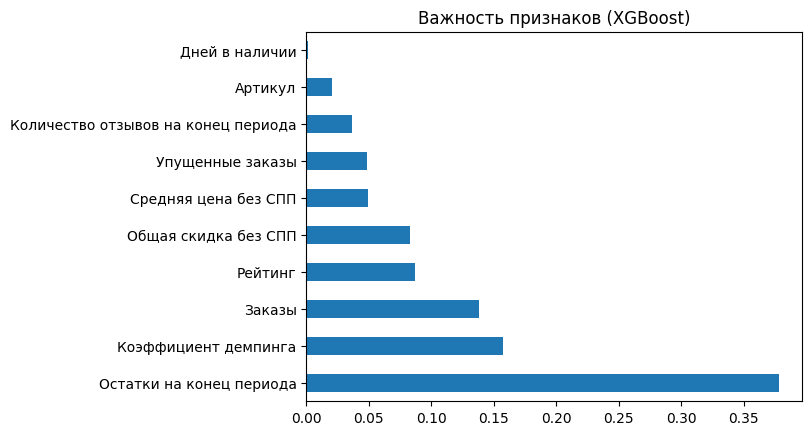

In [107]:
#Анализ важности признаков
print("\n6. Анализ важности признаков...")
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

importances.plot(kind='barh', title='Важность признаков (XGBoost)')
plt.show()

In [108]:
#Функция прогнозирования
def predict_position(model, scaler, feature_names, input_values):
    input_df = pd.DataFrame([input_values], columns=feature_names)
    input_scaled = scaler.transform(input_df)
    return model.predict(input_scaled)[0]

# Пример товара из исходного датасета
example_row = df.sample(n=1).iloc[0]
example_features = example_row.drop('Позиция в выдаче').to_dict()
example_target = example_row['Позиция в выдаче']

print("\n📊 Пример товара (оригинальные значения):")
for k, v in example_features.items():
    print(f"{k}: {v}")
print("Текущая позиция в выдаче:", example_target)



📊 Пример товара (оригинальные значения):
Артикул: 242904339.0
Заказы: 470.0
Средняя цена без СПП: 1122.77
Коэффициент демпинга: 0.0
Остатки на конец периода: 2483.0
Дней в наличии: 30.0
Общая скидка без СПП: 43.37
Упущенные заказы: 0.0
Рейтинг: 4.8
Количество отзывов на конец периода: 294.0
Текущая позиция в выдаче: 73.0


In [120]:
import numpy as np
import pandas as pd

# 9. Функция случайного поиска с реалистичными ограничениями
def random_search_optimization(model, scaler, feature_names, current_values, bounds, num_combinations=5000, improvement_threshold=5):
    initial_rank = predict_position(model, scaler, feature_names, current_values)
    best_improvement = -np.inf
    best_params = current_values.copy()

    for _ in range(num_combinations):
        # Генерируем случайные параметры
        random_params = {}
        for key, (lower, upper) in bounds.items():
            if isinstance(current_values[key], int):
                random_params[key] = np.random.randint(lower, upper + 1)
            else:
                random_params[key] = round(np.random.uniform(lower, upper), 2)

        # Прогнозируем позицию
        predicted_rank = predict_position(model, scaler, feature_names, random_params)

        # Считаем улучшение
        improvement = initial_rank - predicted_rank

        # Проверяем, лучше ли это текущего
        if improvement > best_improvement:
            best_improvement = improvement
            best_params = random_params
            best_rank = predicted_rank # Store the rank associated with the best parameters

    # Oкругляем best_improvement и best_rank
    best_improvement = round(best_improvement, 2)
    # best_rank = round(predicted_rank, 2) # This was causing the error, as predicted_rank was not defined outside the loop

    # Вывод результата
    print(f"\n📊 Исходная позиция: {initial_rank:.2f}")
    print(f"📉 Лучшая найденная позиция: {max(1.0, best_rank):.2f}") # Use best_rank here
    print(f"📈 Изменение: {best_improvement:.2f} позиций")

    if best_improvement >= improvement_threshold:
        print("\n✅ РЕКОМЕНДАЦИЯ: Эти параметры значительно улучшат позицию товара")
        print("Лучшие параметры:")
        for k, v in best_params.items():
            print(f"  {k}: {v} (было: {current_values[k]})")
    elif best_improvement > 0:
        print("\n🟡 Небольшое улучшение найдено")
        print("Можно рассмотреть, но эффект ограничен")
        print("Лучшие параметры:")
        for k, v in best_params.items():
            print(f"  {k}: {v} (было: {current_values[k]})")
    else:
        print("\n❌ Улучшения не найдено")
        print("Все найденные комбинации параметров ухудшают позицию")
        print("Рассмотрите изменение бизнес-стратегии или сбор дополнительных данных")

    return best_params, best_rank, best_improvement # Add return statement

# 10. Пример использования
# Выбираем товар из датасета
example_row = df.sample(n=9).iloc[0]
current_values = example_row.drop('Позиция в выдаче').to_dict()
current_actual_rank = example_row['Позиция в выдаче']

print(f"🛒 Выбранный товар: позиция в выдаче — {current_actual_rank}")
print("Текущие параметры:")
for k, v in current_values.items():
    print(f"  {k}: {v}")

# Определяем, какие параметры можно менять, и в каком диапазоне
available_features = X.columns.tolist()
print("\n🔧 Доступные признаки для изменения:", available_features)

# Задаём границы изменения только для управляемых параметров
bounds = {}
price_key = 'Средняя цена без СПП'
discount_key = 'Общая скидка без СПП'
stock_key = 'Остатки на конец периода'
damping_key = 'Коэффициент демпинга'

# Добавляем только те параметры, которые есть в данных и могут быть изменены
if price_key in available_features:
    bounds[price_key] = (current_values[price_key] * 0.8, current_values[price_key] * 1.0)  # снижение цены до 20%
if discount_key in available_features:
    bounds[discount_key] = (current_values[discount_key], min(current_values[discount_key] + 15, 80))  # увеличение скидки максимум на 15%
if stock_key in available_features:
    bounds[stock_key] = (current_values[stock_key], current_values[stock_key] * 2)  # удвоение остатков
if damping_key in available_features:
    bounds[damping_key] = (0, 5)  # коэффициент демпинга от 0 до 2


print("\n🔍 Параметры, которые мы можем изменять:")
for k, v in bounds.items():
    print(f"  {k}: {v}")

# Запуск оптимизации
best_params, best_rank, improvement = random_search_optimization(
    model, scaler, X.columns, current_values, bounds,
    num_combinations=5000, improvement_threshold=10
)

🛒 Выбранный товар: позиция в выдаче — 85.0
Текущие параметры:
  Артикул: 242898081.0
  Заказы: 1068.0
  Средняя цена без СПП: 1352.23
  Коэффициент демпинга: 0.0
  Остатки на конец периода: 7137.0
  Дней в наличии: 30.0
  Общая скидка без СПП: 52.83
  Упущенные заказы: 0.0
  Рейтинг: 4.8
  Количество отзывов на конец периода: 1357.0

🔧 Доступные признаки для изменения: ['Артикул', 'Заказы', 'Средняя цена без СПП', 'Коэффициент демпинга', 'Остатки на конец периода', 'Дней в наличии', 'Общая скидка без СПП', 'Упущенные заказы', 'Рейтинг', 'Количество отзывов на конец периода']

🔍 Параметры, которые мы можем изменять:
  Средняя цена без СПП: (1081.784, 1352.23)
  Общая скидка без СПП: (52.83, 67.83)
  Остатки на конец периода: (7137.0, 14274.0)
  Коэффициент демпинга: (0, 5)

📊 Исходная позиция: 84.98
📉 Лучшая найденная позиция: 13.42
📈 Изменение: 71.56 позиций

✅ РЕКОМЕНДАЦИЯ: Эти параметры значительно улучшат позицию товара
Лучшие параметры:
  Средняя цена без СПП: 1276.65 (было: 1352.2